TensorFlow version: 2.18.0
Loading and preparing data...
Splitting data...
Scaling features...


d:\solar_energy_forecast\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model...


d:\solar_energy_forecast\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 525948576.0000 - val_loss: 167280144.0000 - learning_rate: 5.0000e-04
Epoch 2/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 253216128.0000 - val_loss: 159809776.0000 - learning_rate: 5.0000e-04
Epoch 3/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 179922912.0000 - val_loss: 182410416.0000 - learning_rate: 5.0000e-04
Epoch 4/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 180409008.0000 - val_loss: 152462592.0000 - learning_rate: 5.0000e-04
Epoch 5/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 175491184.0000 - val_loss: 158655520.0000 - learning_rate: 5.0000e-04
Epoch 6/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 173986192.0000 - val_loss: 145220352.0000 - learning_rate: 5.0000e-04
Epoch 7/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 178600560.0000 - val_loss: 175799072.0000 - learning_rate: 5.0000e-04
Epoch 8/50
1112/1112 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 171023120.000

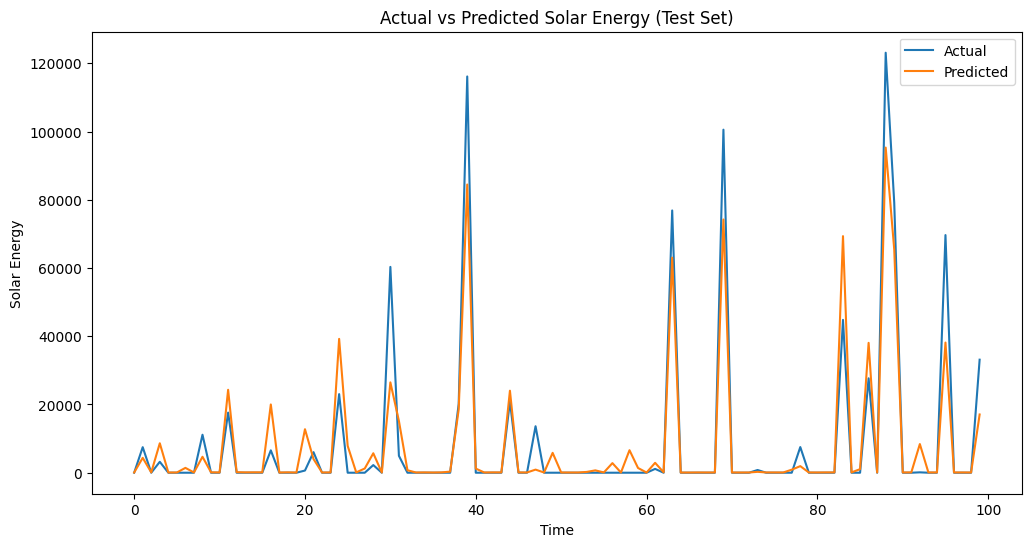

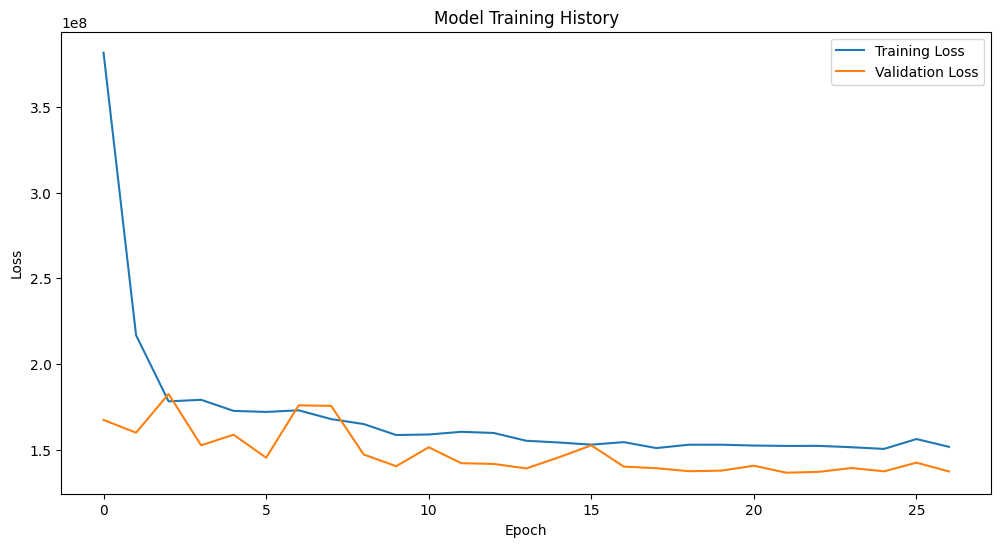

False Positive Rate: 1.53%
Model saved to: d:\solar_energy_forecast\results\models\solar_energy_forecast_model.h5


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Version of Tensorflow used
print(f"TensorFlow version: {tf.__version__}")

np.random.seed(42)
tf.random.set_seed(42)

class TimeSeriesGenerator(Sequence):
    """
     A modified data Generator that extends keras sequence class for time series data
+    It is intended to produce data in batches for training
    """
    def __init__(self, X, y, batch_size=32, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """
        Gives back how many batches there are in each epoch
        This is calculated by dividing the batch size by the total number of samples
        """
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.X))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        # Giving back the batch of features and intended targets
        return self.X[batch_indexes], self.y[batch_indexes]

    def on_epoch_end(self):
        """
        The indexes are shuffled after each epoch to ensure random sampling
        This is useful in training to avoid overfitting
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

# data loading and pre useage the time series data 
def load_and_prepare_data(file_path, chunk_size=10000):

    # Reading the data in chunks 
    chunks = pd.read_csv(file_path, parse_dates=['datetime'], chunksize=chunk_size)
    
    # extracting the input features and target variable
    features = ['temp', 'humidity', 'windspeed', 'cloudcover', 'solarradiation']
    target = 'solar_energy'
    
    X_list = []
    y_list = []
    sequence_length = 24 
    forecast_horizon = 36
    
    # Looping through the chunks
    for chunk in chunks:
        chunk.set_index('datetime', inplace=True)
        chunk = chunk.sort_index()

        # Making corresponding targets and sequences of a given length
        for i in range(len(chunk) - sequence_length - forecast_horizon + 1):
            X_list.append(chunk[features].values[i:(i + sequence_length)])
            y_list.append(chunk[target].values[i + sequence_length + forecast_horizon - 1])

            if len(X_list) >= chunk_size:
                yield np.array(X_list), np.array(y_list)
                X_list = []
                y_list = []

    if X_list:
        yield np.array(X_list), np.array(y_list)

# Root File and path to processed data
project_root = os.path.dirname(os.getcwd())
processed_data_path = os.path.join(project_root, "data", "processed", "processed_data.csv")

X_all = []
y_all = []

print("Loading and preparing data...")
for X_chunk, y_chunk in load_and_prepare_data(processed_data_path):
    X_all.append(X_chunk)
    y_all.append(y_chunk)

# concatenating all batch into single np array
X = np.concatenate(X_all)
y = np.concatenate(y_all)

# splitting the data 80% - 20%
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Scaling the features
print("Scaling features...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Construct data generators for validation and training
train_gen = TimeSeriesGenerator(X_train_scaled, y_train, batch_size=64)
val_gen = TimeSeriesGenerator(X_val_scaled, y_val, batch_size=64)

# SimpleRNN MODEL
model = Sequential([
    SimpleRNN(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
]

print("Training model...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

print("Evaluating model...")
y_pred = model.predict(X_test_scaled, batch_size=64)

# statistical numbers
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Visualisation
# plotting actual vs predicted

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.title('Actual vs Predicted Solar Energy (Test Set)')
plt.xlabel('Time')
plt.ylabel('Solar Energy')
plt.legend()
plt.savefig(os.path.join(project_root, "results", "figures", "actual_vs_predicted.png"))
plt.show()


# plotting model training
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(project_root, "results", "figures", "training_history.png"))
plt.show()

def calculate_threshold():
    """
    Determine the cutoff point for judging the significance of the solar energy forecast.
    For computations, fixed constants are assumed
    """
    N_colchester = 75000 # Total units in colchester
    N_pilot = N_colchester * 0.12 # pilot units
    E = 0.5 # Efficiency factor
    K = 5 # Constant multiplier

    return N_pilot * E * K + N_colchester * E

threshold = calculate_threshold()

# Generate binary classifications based on the threshold for actual and predicted data.
y_test_binary = y_test > threshold
y_pred_binary = y_pred.flatten() > threshold

false_positives = np.logical_and(y_pred_binary, np.logical_not(y_test_binary))
false_positive_rate = false_positives.sum() / len(y_test)

print(f"False Positive Rate: {false_positive_rate:.2%}")

# Saving the model
model_save_path = os.path.join(project_root, "results", "models", "solar_energy_forecast_model.h5")
model.save(model_save_path)